<a href="https://colab.research.google.com/github/haziranz/classification-DM-/blob/main/titanic_decision_tree_complete_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Workspace preparation**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from sklearn import preprocessing

from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC
plt.style.use('ggplot')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


**Searching for folders inside input folder**

In [2]:
from subprocess import check_output
print(check_output(["ls", "/content"]).decode("utf8"))

sample_data
test.csv
train.csv



**Loading data file**

In [3]:
dataset = pd.read_csv('/content/train.csv')
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
dataset.describe(include = "all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Thayer, Mr. John Borland",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [5]:
dataset.shape

(891, 12)

**Missing value identification/ handling**

In [6]:
dataset.isnull().sum(axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

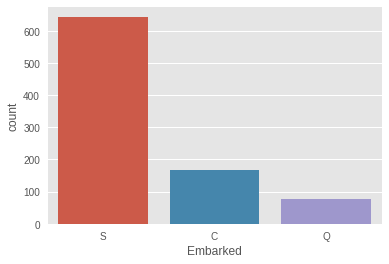

In [7]:
sns.countplot(dataset['Embarked'])

In [8]:
# File missing values in embarked with S which is the most frequent item.
dataset = dataset.fillna({"Embarked": "S"})

**Handling categorical variables**

In [9]:
## One hot encoding is used since no ordering is available for Sex (male, female) feature.
dataset = pd.get_dummies(dataset, columns=['Sex'])
dataset.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,1,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,1,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,0,1


In [10]:
## One hot encoding is used since no ordering is available for Sex (male, female) feature.
dataset = pd.get_dummies(dataset, columns=['Embarked'])
dataset.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,1,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0,1,0,0,1


**Applying model - with default values**

In [11]:
feat_names = ['Pclass', 'Sex_male', 'Sex_female', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Parch', 'SibSp', 'Fare']
targ_names = ['Dead (0)', 'Survived (1)'] # 0 - Dead, 1 - Survived

train_class = dataset[['Survived']]
train_feature = dataset[feat_names]
train_feature.head()

,Pclass,Sex_male,Sex_female,Embarked_C,Embarked_Q,Embarked_S,Parch,SibSp,Fare
0,3,1,0,0,0,1,0,1,7.2500
1,1,0,1,1,0,0,0,1,71.2833
2,3,0,1,0,0,1,0,0,7.9250
3,1,0,1,0,0,1,0,1,53.1000
4,3,1,0,0,0,1,0,0,8.0500


In [12]:
clf = DecisionTreeClassifier(random_state=0)
scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_macro': 'recall_macro',
           'f1_macro': 'f1_macro'}
scores = cross_validate(clf, train_feature, train_class, cv=10, scoring=scoring)
# print(scores.keys())

print ('Accuracy score : %.3f' % scores['test_acc'].mean())
print ('Precisoin score : %.3f' % scores['test_prec_macro'].mean())
print ('Recall score : %.3f' % scores['test_rec_macro'].mean())
print ('F1 score : %.3f' % scores['test_f1_macro'].mean())

Accuracy score : 0.805
Precisoin score : 0.798
Recall score : 0.785
F1 score : 0.789


**Parameter tuning - gridSearchCV**

In [13]:
para_grid = {
    'min_samples_split' : range(10,500,20),
    'max_depth': range(1,20,2),
    'criterion': ("gini", "entropy")
}

clf_tree = DecisionTreeClassifier()
clf_cv = GridSearchCV(clf_tree,
                   para_grid,
                   scoring='accuracy',
                   cv=5,
                   n_jobs=-1)
clf_cv.fit(train_feature,train_class)

best_parameters = clf_cv.best_params_
print(best_parameters)

{'criterion': 'gini', 'max_depth': 11, 'min_samples_split': 50}


**Model evaluation with tuned parameters using cross validation**

In [14]:
clf = clf_cv.best_estimator_
scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_macro': 'recall_macro',
           'f1_macro': 'f1_macro'}
scores = cross_validate(clf, train_feature, train_class, cv=10, scoring=scoring)
#print(scores.keys())

print ('Accuracy score : %.3f' % scores['test_acc'].mean())
print ('Precisoin score : %.3f' % scores['test_prec_macro'].mean())
print ('Recall score : %.3f' % scores['test_rec_macro'].mean())
print ('F1 score score : %.3f' % scores['test_f1_macro'].mean())

Accuracy score : 0.799
Precisoin score : 0.803
Recall score : 0.768
F1 score score : 0.777


**Classification report analysis**

In [15]:
# Create a holdout sample for further testing
# train_class, train_feature
X_train, X_test, y_train, y_test = train_test_split(train_feature, train_class, test_size=0.33)
print (str(X_train.shape) +","+ str(y_train.shape))
print (str(X_test.shape) +","+ str(y_test.shape))

(596, 9),(596, 1)
(295, 9),(295, 1)


In [16]:
clf2 = clf_cv.best_estimator_
clf2.fit(X_train,y_train)
predictions = clf2.predict(X_test)
print(metrics.classification_report(y_test,predictions, target_names=targ_names, digits=3))

              precision    recall  f1-score   support

    Dead (0)      0.762     0.939     0.842       181
Survived (1)      0.847     0.535     0.656       114

    accuracy                          0.783       295
   macro avg      0.805     0.737     0.749       295
weighted avg      0.795     0.783     0.770       295



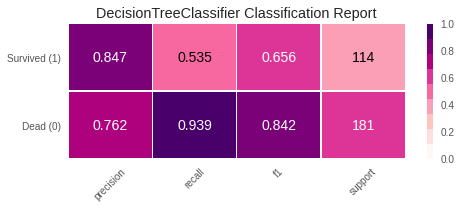

In [17]:
fig, ax = plt.subplots(figsize=(7,3))
visualizer = ClassificationReport(clf2, classes=targ_names, support=True, cmap='RdPu')
visualizer.score(X_test, y_test)
for label in visualizer.ax.texts:
    label.set_size(14)
g = visualizer.poof()

**Confusion Matrix**

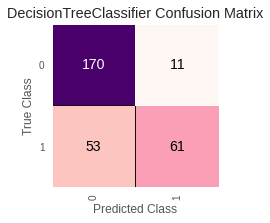

In [18]:
fig, ax = plt.subplots(figsize=(3,3))
cm = ConfusionMatrix(clf2, classes=[0, 1], cmap='RdPu')
cm.score(X_test, y_test)
for label in cm.ax.texts:
    label.set_size(14)
cm.poof()

**ROC Curve**

0.7830508474576271

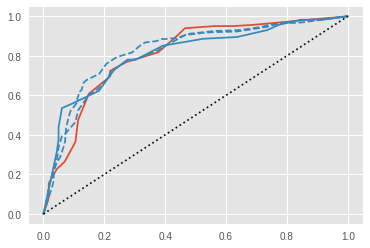

In [20]:
modelviz = clf_cv.best_estimator_
visualizer = ROCAUC(modelviz, classes=["Dead", "Survived"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
                      # Finalize and render the figure

**Draw the decision tree using graphviz**



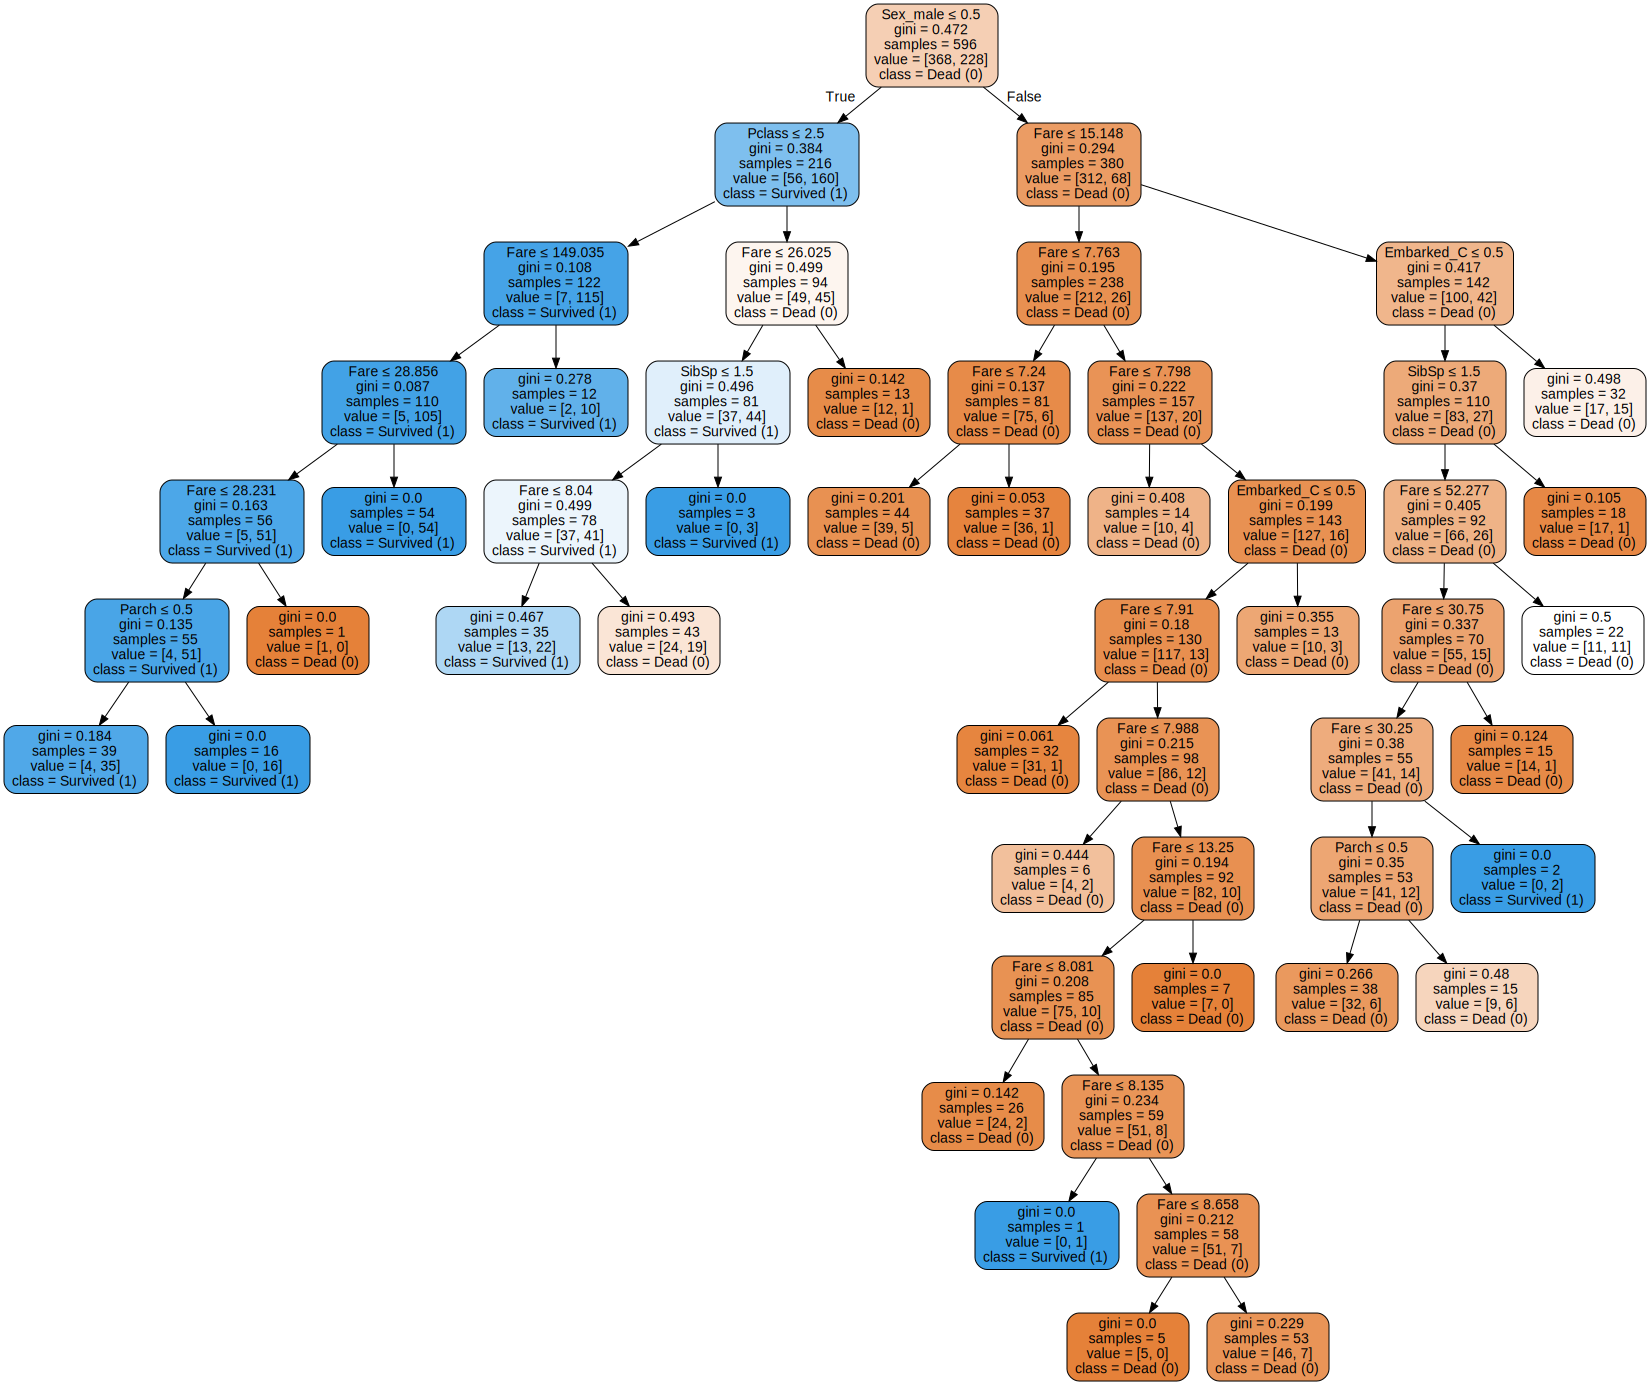

In [21]:
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz

data = export_graphviz(clf,out_file=None,feature_names=feat_names,class_names=targ_names,   
                         filled=True, rounded=True,  
                         special_characters=True)
graph = graphviz.Source(data)
graph

**Understanding Feature Importance**

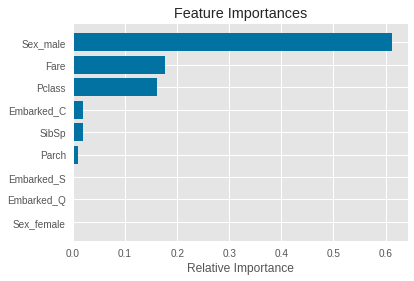

In [22]:
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feat_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

**Creating submission file**

In [25]:
# Loading test dataset
test = pd.read_csv('/content/test.csv')

# Fit the model
clf.fit(train_feature, train_class)

# Replace missing Fare values with mean
meanFare = dataset['Fare'].mean()
test = test.fillna({"Fare": meanFare})
# Categorical -> One hot encoding
test = pd.get_dummies(test, columns=['Sex'])
test = pd.get_dummies(test, columns=['Embarked'])

#set ids as PassengerId and predict survival
ids = test['PassengerId']
test_feature = test[feat_names]
predictions = clf.predict(test_feature)

#set the output as a dataframe and convert to csv file named submission.csv
output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [26]:
output.to_csv('submission.csv', index=False)